In [1]:
import numpy as np
import pandas as pd
import sys
import cv2

import time
import torch
import torch.nn as nn
from PIL import Image

sys.path.append('/kaggle/input/sennet-score/src')
from surface_dice import create_table_neighbour_code_to_surface_area

di = '/root/data'
device = torch.device('cuda')  # can be 'cpu'

# PyTorch version dependence on index data type
torch_ver_major = int(torch.__version__.split('.')[0])
dtype_index = torch.int32 if torch_ver_major >= 2 else torch.long

/tmp/ipykernel_21447/2017681299.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def rle_decode(mask_rle: str, shape: tuple) -> np.array:
    """
    Decode rle string
    https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
    https://www.kaggle.com/stainsby/fast-tested-rle

    Args:
      mask_rle: run length (rle) as string
      shape: (height, width) of the mask

    Returns:
      array[uint8], 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def compute_area(y: list, unfold: nn.Unfold, area: torch.Tensor) -> torch.Tensor:
    """
    Args:
      y (list[Tensor]): A pair of consecutive slices of mask
      unfold: nn.Unfold(kernel_size=(2, 2), padding=1)
      area (Tensor): surface area for 256 patterns (256, )

    Returns:
      Surface area of surface in 2x2x2 cube
    """
    # Two layers of segmentation masks
    yy = torch.stack(y, dim=0).to(torch.float16).unsqueeze(0)
    # (batch_size=1, nch=2, H, W) 
    # bit (0/1) but unfold requires float

    # unfold slides through the volume like a convolution
    # 2x2 kernel returns 8 values (2 channels * 2x2)
    cubes_float = unfold(yy).squeeze(0)  # (8, n_cubes)

    # Each of the 8 values are either 0 or 1
    # Convert those 8 bits to one uint8
    cubes_byte = torch.zeros(cubes_float.size(1), dtype=dtype_index, device=device)
    # indices are required to be int32 or long for area[cube_byte] below, not uint8
    # Can be int32 for torch 2.0.0, int32 raise IndexError in torch 1.13.1.
    
    for k in range(8):
        cubes_byte += cubes_float[k, :].to(dtype_index) << k

    # Use area lookup table: pattern index -> area [float]
    cubes_area = area[cubes_byte]

    return cubes_area

def fill_outline(outline: np.ndarray) -> torch.Tensor:
    """
    expects 2d numpy array of 0s and 1s
    """
    outline = (outline * 255)

    contours, _ = cv2.findContours(outline, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_image = np.zeros_like(outline)
    cv2.drawContours(filled_image, contours, -1, (255), thickness=cv2.FILLED)
    return (filled_image).astype(bool)

def compute_surface_dice_score(submit: pd.DataFrame, label: pd.DataFrame) -> float:
    """
    Compute surface Dice score for one 3D volume

    submit (pd.DataFrame): submission file with id and rle
    label (pd.DataFrame): ground truth id, rle, and also image height, width
    """
    # submit and label must contain exact same id in same order
    assert (submit['id'] == label['id']).all()
    assert len(label) > 0
    agg_dice = []

    # All height, width must be the same
    len(label['height'].unique()) == 1
    len(label['width'].unique()) == 1

    # Surface area lookup table: Tensor[float32] (256, )
    area = create_table_neighbour_code_to_surface_area((1, 1, 1))
    area = torch.from_numpy(area).to(device)  # torch.float32

    # Slide through the volume like a convolution
    unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)

    r = label.iloc[0]
    h, w = r['height'], r['width']
    n_slices = len(label)

    # Padding before first slice
    y0 = y0_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

    num = 0     # numerator of surface Dice
    denom = 0   # denominator
    for i in range(n_slices + 1):
        # Load one slice
        if i < n_slices:
            r = label.iloc[i]
            y1 = rle_decode(r['rle'], (h, w))
            y1 = torch.from_numpy(y1).to(device)

            r = submit.iloc[i]
            y1_pred = rle_decode(r['rle'], (h, w))
            y1_pred = torch.from_numpy(fill_outline(y1_pred)).to(device)
        else:
            # Padding after the last slice
            y1 = y1_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

        # Compute the surface area between two slices (n_cubes,)
        area_pred = compute_area([y0_pred, y1_pred], unfold, area)
        area_true = compute_area([y0, y1], unfold, area)

        # True positive cube indices
        idx = torch.logical_and(area_pred > 0, area_true > 0)

        # Surface dice numerator and denominator
        slice_num = area_pred[idx].sum() + area_true[idx].sum()
        slice_denom = area_pred.sum() + area_true.sum()
        agg_dice.append(slice_num.clamp(min=1e-8) / slice_denom.clamp(min=1e-8))
        num += slice_num
        denom += slice_denom

        # Next slice
        y0 = y1
        y0_pred = y1_pred

    dice = num / denom.clamp(min=1e-8)
    return dice.item(), torch.stack(agg_dice)

def add_size_columns(df: pd.DataFrame):
    """
    df (DataFrame): including id column, e.g., kidney_1_dense_0000
    """
    widths = []
    heights = []
    subdirs = []
    nums = []
    for i, r in df.iterrows():
        file_id = r['id']
        subdir = file_id[:-5]    # kidney_1_dense
        file_num = file_id[-4:]  # 0000

        filename = '%s/train/%s/images/%s.tif' % (di, subdir, file_num)
        img = Image.open(filename)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        subdirs.append(subdir)
        nums.append(file_num)

    df['width'] = widths
    df['height'] = heights
    df['image_id'] = subdirs
    df['slice_id'] = nums


In [3]:
255 * 0.3

76.5

In [4]:
import numpy as np

arr = np.random.randint(0, 2, (10, 10))

In [5]:
arr.astype(bool).astype(np.uint8) *255

array([[  0, 255,   0, 255,   0, 255,   0, 255,   0, 255],
       [  0, 255, 255, 255,   0, 255,   0,   0, 255, 255],
       [  0,   0, 255,   0,   0, 255, 255, 255,   0, 255],
       [255,   0,   0,   0,   0,   0,   0, 255,   0, 255],
       [255, 255, 255, 255,   0, 255,   0, 255,   0, 255],
       [255, 255,   0,   0, 255, 255, 255,   0,   0,   0],
       [  0, 255, 255, 255,   0,   0,   0, 255, 255, 255],
       [  0, 255,   0, 255, 255,   0,   0,   0, 255,   0],
       [  0, 255, 255,   0,   0,   0, 255, 255,   0,   0],
       [255, 255, 255,   0, 255,   0,   0, 255, 255, 255]], dtype=uint8)

In [23]:
kidney_id = "kidney_3_dense"
submission_pth = "../exp7_ry_model/submission.csv"

submit = pd.read_csv(submission_pth)
idx = submit['id'].str.startswith(kidney_id)
submit = submit[idx]
submit.reset_index(drop=True, inplace=True)

i = 400
submit[i:i+10]

,id,rle
400,kidney_3_dense_0896,499130 2 500639 5 502148 7 503657 8 505166 10 ...
401,kidney_3_dense_0897,403407 3 404917 1 404919 1 464348 2 465860 1 4...
402,kidney_3_dense_0898,615409 1 616917 3 618428 1 687792 1 689301 2 6...
403,kidney_3_dense_0899,564900 1 566411 1 615410 1 686282 1 687791 3 6...
404,kidney_3_dense_0900,456257 1 613901 2 615411 1 686282 2 687791 3 6...
405,kidney_3_dense_0901,413896 2 415405 4 416915 3 576933 2 578442 3 6...
406,kidney_3_dense_0902,612394 2 684772 1 686282 2 722538 5 724046 8 7...
407,kidney_3_dense_0903,684772 2 686282 2 715001 2 716508 4 718017 4 7...
408,kidney_3_dense_0904,607868 1 609377 1 683262 1 684772 2 711982 1 7...
409,kidney_3_dense_0905,683262 1 710472 3 711981 5 713489 6 714998 7 7...


In [24]:
label = pd.read_csv(di + '/train_rles.csv')
idx = label['id'].str.startswith(kidney_id)
label = label[idx]
label.reset_index(drop=True, inplace=True)
assert len(label) > 0
add_size_columns(label)

i = 400
label[i:i+10]

,id,rle,width,height,image_id,slice_id
400,kidney_3_dense_0896,601646 1 618425 2 619935 2 624424 1 625907 1 6...,1510,1706,kidney_3_dense,0896
401,kidney_3_dense_0897,601646 2 616917 2 618426 2 622914 1 624397 1 6...,1510,1706,kidney_3_dense,0897
402,kidney_3_dense_0898,601647 1 615409 1 616917 4 618427 2 622914 1 6...,1510,1706,kidney_3_dense,0898
403,kidney_3_dense_0899,615410 1 616920 1 621403 2 622914 1 686283 1 6...,1510,1706,kidney_3_dense,0899
404,kidney_3_dense_0900,613901 3 615410 2 686282 2 687791 3 689301 2 7...,1510,1706,kidney_3_dense,0900
405,kidney_3_dense_0901,612393 3 613902 3 686282 2 687792 2 724047 3 7...,1510,1706,kidney_3_dense,0901
406,kidney_3_dense_0902,610885 2 612394 2 684772 2 686282 2 687793 1 7...,1510,1706,kidney_3_dense,0902
407,kidney_3_dense_0903,610886 1 684771 3 686282 2 713492 1 715001 3 7...,1510,1706,kidney_3_dense,0903
408,kidney_3_dense_0904,683262 1 684772 2 711981 3 713489 5 714998 6 7...,1510,1706,kidney_3_dense,0904
409,kidney_3_dense_0905,681752 1 683262 2 710472 3 711981 5 713488 7 7...,1510,1706,kidney_3_dense,0905


In [25]:
sd_total, sd_slices = compute_surface_dice_score(submit, label)
sd_total, sd_slices.mean()

(0.8345681428909302, tensor(0.8253, device='cuda:0'))

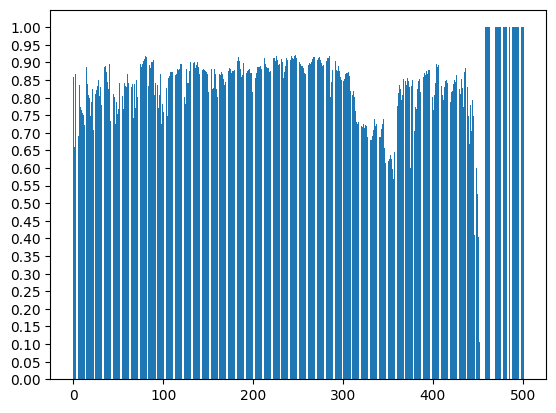

In [26]:
from matplotlib import pyplot as plt

plt.bar(range(len(sd_slices)), sd_slices.cpu().numpy())
plt.yticks([i/20 for i in range(int(max(sd_slices.cpu().numpy())*20)+1)])
plt.show()


In [ ]:
torch.Tensor([True]).bool() * 255

tensor([255])